<a href="https://colab.research.google.com/github/hmelino/Notebooks/blob/master/M5_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#M5 Forecasting

Kaggle's competition M5 Forecasting - Accuracy dataset consist of Walmart's sales dataset across their shops in 3 states of America. In this notebook we will try to predict sales for 28 days. 

For most of time we will use really powerfull Pandas functions, but for more complicated dataset transformations we will have to design our own ones.


##Model
Facebook's Prophet will be model of our choice.
- easy to use without expert knowledge on statistics or time series forecasting
- allows to use multiple seasonabilities 
- easy to input holiday effects

##Objectives :
- inspect and analyse this dataset
- extract holiday from calendar and add it to our model
- train and predict future 28 days sales
- apply prices on predicted sales

.. and the most important one - have some fun while exploring data and coding :)

##Imports

In [1]:
import pandas as pd

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation , performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import numpy as np
from tqdm.notebook import tqdm
import pickle
import datetime

pd.options.display.float_format = '{:20,.2f}'.format

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



##Variables

In [2]:
calendar=pd.read_csv('/content/drive/My Drive/Reports/m5-forecasting-accuracy/calendar.csv')
sales_train_val=pd.read_csv('/content/drive/My Drive/Reports/m5-forecasting-accuracy/sales_train_validation.csv')
sample_sub=pd.read_csv('/content/drive/My Drive/Reports/m5-forecasting-accuracy/sample_submission.csv')[:30490]
sell_prices=pd.read_csv('/content/drive/My Drive/Reports/m5-forecasting-accuracy/sell_prices.csv')

sales_train_val is the main dataset. It contain the sale data for an individual items in each store. Row for each item have store location, item id, department id and sales for period of 1913 days.

In [3]:
sales_train_val

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,0,0,3,4,4,0,0,1,0,1,1,7,7,3,6,3,3,7,12,4,2,7,5,12,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,1,0,0,0,0,3,1,1,1,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,2,7,5,3,5,20,8,10,3,3,4,7,2,3,5,6,3,4,1,2,5,1,2,2,2,...,1,1,2,0,0,2,0,0,0,2,0,1,1,0,0,0,0,1,1,2,1,4,0,0,2,2,4,0,0,0,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,2,1,1,2,4,3,0,0,0,0,0,1,1,2,1,1,1,1,2,0,1,0,3,0,0,1,0,0,1,0,3,1,3


#Seasonality
For this competition we have been provided with calendar dataset as well.

In [4]:
calendar.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


Using dictionary below we will extract all event names and will attach event dates to each name.

In [5]:
holiday1_dic={holidayName:[date for date in calendar.loc[calendar['event_name_1']==holidayName]['date'].values] for holidayName in calendar['event_name_1'].unique()}

In [6]:
holiday1_dic

{'Chanukah End': ['2011-12-28',
  '2012-12-16',
  '2013-12-05',
  '2014-12-24',
  '2015-12-14'],
 'Christmas': ['2011-12-25',
  '2012-12-25',
  '2013-12-25',
  '2014-12-25',
  '2015-12-25'],
 'Cinco De Mayo': ['2011-05-05',
  '2012-05-05',
  '2014-05-05',
  '2015-05-05',
  '2016-05-05'],
 'ColumbusDay': ['2011-10-10',
  '2012-10-08',
  '2013-10-14',
  '2014-10-13',
  '2015-10-12'],
 'Easter': ['2012-04-08',
  '2013-03-31',
  '2014-04-20',
  '2015-04-05',
  '2016-03-27'],
 'Eid al-Fitr': ['2011-08-31',
  '2012-08-19',
  '2013-08-08',
  '2014-07-29',
  '2015-07-18'],
 'EidAlAdha': ['2011-11-07',
  '2012-10-26',
  '2013-10-15',
  '2014-10-04',
  '2015-09-24'],
 "Father's day": ['2011-06-19', '2012-06-17', '2013-06-16', '2015-06-21'],
 'Halloween': ['2011-10-31',
  '2012-10-31',
  '2013-10-31',
  '2014-10-31',
  '2015-10-31'],
 'IndependenceDay': ['2011-07-04',
  '2012-07-04',
  '2013-07-04',
  '2014-07-04',
  '2015-07-04'],
 'LaborDay': ['2011-09-05',
  '2012-09-03',
  '2013-09-02',
  '20

Now its the time to transform our dictionary to a dataframe compactible with Facebook's Prophet. It is required to have a name of holiday under column 'holiday' and dates as column 'ds'.

In [7]:
holiday1_list=[pd.DataFrame({'holiday':hol_name,'ds':pd.to_datetime(dates)}) for hol_name,dates in holiday1_dic.items()]

In [8]:
holiday1_list[1]

,holiday,ds
0,SuperBowl,2011-02-06
1,SuperBowl,2012-02-05
2,SuperBowl,2013-02-03
3,SuperBowl,2014-02-02
4,SuperBowl,2015-02-01
5,SuperBowl,2016-02-07


All converted dataframes will be joint in main holiday dataframe.

In [9]:
%%time
holiday = pd.DataFrame(columns=['holiday','ds'])
for d in holiday1_list:
  holiday = pd.concat([holiday,d])


CPU times: user 31.3 ms, sys: 2.42 ms, total: 33.7 ms
Wall time: 32 ms


In [10]:
holiday

,holiday,ds
0,SuperBowl,2011-02-06
1,SuperBowl,2012-02-05
2,SuperBowl,2013-02-03
3,SuperBowl,2014-02-02
4,SuperBowl,2015-02-01
...,...,...
0,Easter,2012-04-08
1,Easter,2013-03-31
2,Easter,2014-04-20
3,Easter,2015-04-05


#Main Dataframe

One of the best ways to start data transformation is to remove all columns that will not be needed.

 'item_id','dept_id','cat_id','store_id','state_id' are already covered in main 'id' column.

In [11]:
%%time
df=sales_train_val.drop(['item_id','dept_id','cat_id','store_id','state_id'],axis=1).set_index(sales_train_val['id']\
                                                                                 .str[:-11])\
                                                                                 .T[1:]\
                                                                                 .set_index(calendar['date'][:1913])

cat_list = list(df.columns)
future = pd.DataFrame({'ds':pd.date_range(start='2016-04-25',end='2016-05-23',freq='d')})
column = 'HOBBIES_1_001_CA_1'

CPU times: user 5 s, sys: 774 ms, total: 5.77 s
Wall time: 5.78 s


By default, Facebook Prophet will include training data in predictions. 

However with such a big dataset, every second of computing time is precious. To speed up such a time consuming task we will specify 28 days we want to predict.

In [12]:
future = pd.DataFrame({'ds':pd.date_range(start='2016-04-25',end='2016-05-26')})

#Fit & Predict

Because we are dealing with large data, this function was designed to speed up prediction as much as possible. 
- specify seasonality
-uncertainity_samples=0 as we dont need values for yhat lower and yhat upper

Adding holiday is the only step that will slow down our model. But added accuracy will be worth it.

In [13]:
  %%time
  m = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True,uncertainty_samples=0)
  data = pd.DataFrame({'ds':df[column].index,'y':df[column].values})
  m.fit(data)
  predicted_values = m.predict(future)['yhat'].values

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


CPU times: user 818 ms, sys: 78.6 ms, total: 896 ms
Wall time: 900 ms


#Cross Validations

Prophet already have a cross validation tool that comes with this module and does again, pretty good job.


In [14]:
df_cross_val = cross_validation(m,initial='1095 days',period='365 days',horizon='20 days' )

INFO:fbprophet:Making 3 forecasts with cutoffs between 2014-04-05 00:00:00 and 2016-04-04 00:00:00


In [15]:
df_cross_val.head()

,ds,yhat,y,cutoff
0,2014-04-06,0.49,0,2014-04-05
1,2014-04-07,0.49,1,2014-04-05
2,2014-04-08,0.49,1,2014-04-05
3,2014-04-09,0.49,1,2014-04-05
4,2014-04-10,0.49,0,2014-04-05


In [16]:
performance_metrics(df_cross_val)

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape
0,2 days,2.18,1.47,1.08,0.71
1,3 days,1.44,1.20,1.00,0.56
2,4 days,1.29,1.14,0.92,0.57
3,5 days,0.21,0.46,0.42,0.39
4,6 days,0.38,0.61,0.50,0.39
5,7 days,0.54,0.73,0.67,inf
6,8 days,0.36,0.60,0.58,inf
7,9 days,0.36,0.60,0.58,inf
8,10 days,0.28,0.53,0.50,inf
9,11 days,0.20,0.45,0.42,inf


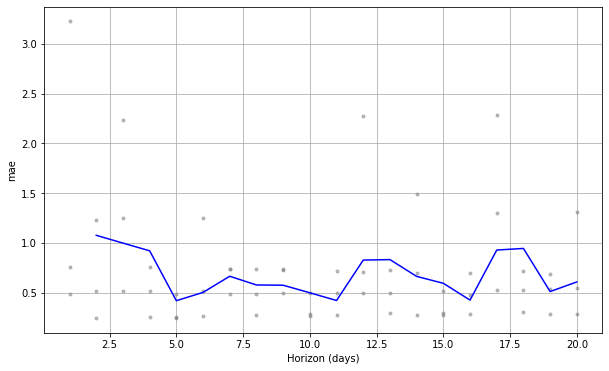

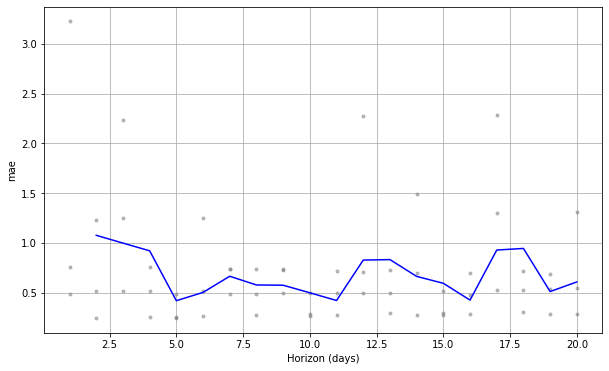

In [17]:
plot_cross_validation_metric(df_cross_val,metric='mae')

Our model is doing pretty well , time for some predictions.

#Fit & Predict 30490 rows

In [18]:
%%time
def run_prophet(column):
  m = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True,uncertainty_samples=0)
  data = pd.DataFrame({'ds':df[column].index,'y':df[column].values})
  m.fit(data)
  return m.predict(future)['yhat'].values

run_prophet(column)

CPU times: user 213 ms, sys: 37.1 ms, total: 250 ms
Wall time: 257 ms




Cell below predicts future sales for 30490 different dataframes. Thats the reason it took more than 7 hours to complete.

To avoid the need of running this cell again, I have saved output to pickle file and attached code with its output in this cell for reference. 


```
[IN]
%%time
out=[]

for n in tqdm(cat_list):
  out.append(run_prophet(n))

import pickle
with open('/content/drive/My Drive/Reports/m5-forecasting-accuracy/prediction.pickle','wb') as pickle_file:
  pickle.dump(out,pickle_file)
```



```
[OUT]
100%|██████████| 30490/30490 [7:08:24<00:00,  1.19it/s]CPU times: user 6h 46min 56s, sys: 21min 52s, total: 7h 8min 49s
Wall time: 7h 8min 24s
```



In [19]:
import pickle
future_sales=pickle.load(open('/content/drive/My Drive/Reports/m5-forecasting-accuracy/predictions.pickle','rb'))

In [20]:
len(future_sales)

30490

After 7 hours of Google's Colabolatory computing time we have a list of predictions for 30490 items , with 28 days of sale data for each item.
It is time to convert it to dataset to perform further calculations.

In [21]:
future_sales[0]

array([0.81087861, 0.80539248, 0.79946431, 0.79306935, 0.78619551,
       0.72358236, 0.60297843, 0.76279178, 0.75416809, 0.74522275,
       0.57968907, 0.72667798, 0.71726285, 0.8248756 , 0.698674  ,
       0.68972776, 0.68116856, 0.67311099, 0.66566503, 0.65893351,
       0.65300963, 0.64797471, 0.64389634, 0.64082676, 0.63880173,
       0.63783981, 0.63794199, 0.63909193])

All arrays with predicted values will be attached to final dataframe. 

In [22]:
%%time
final_df = pd.DataFrame(columns=['id']+[f'F{n}' for n in range(1,29)])
for i in range(len(future_sales)):
  new_row_df = pd.DataFrame(future_sales[i],index=[f'F{n}' for n in range(1,29)]).T
  new_row_df['id']=df.columns[i]
  final_df=pd.concat([final_df,new_row_df])

CPU times: user 1min 31s, sys: 926 ms, total: 1min 32s
Wall time: 1min 32s


In [23]:
final_df.reset_index(drop=True,inplace=True)

In [24]:
final_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1,0.81,0.81,0.80,0.79,0.79,0.72,0.60,0.76,0.75,0.75,0.58,0.73,0.72,0.82,0.70,0.69,0.68,0.67,0.67,0.66,0.65,0.65,0.64,0.64,0.64,0.64,0.64,0.64
1,HOBBIES_1_002_CA_1,0.19,0.20,0.21,0.22,0.23,0.54,0.37,0.28,0.29,0.31,0.57,0.34,0.36,0.29,0.38,0.39,0.40,0.40,0.41,0.41,0.41,0.40,0.40,0.39,0.39,0.38,0.37,0.36
2,HOBBIES_1_003_CA_1,0.69,0.69,0.69,0.69,0.69,0.80,0.60,0.69,0.69,0.69,0.83,0.70,0.70,0.60,0.70,0.70,0.71,0.71,0.71,0.71,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
3,HOBBIES_1_004_CA_1,1.92,1.91,1.91,1.91,1.90,1.60,3.03,1.90,1.91,1.91,1.72,1.92,1.93,2.20,1.95,1.97,1.98,1.99,2.00,2.01,2.02,2.03,2.04,2.05,2.05,2.05,2.05,2.05
4,HOBBIES_1_005_CA_1,0.89,0.86,0.84,0.81,0.79,0.53,0.89,0.74,0.73,0.72,0.27,0.73,0.74,0.59,0.78,0.81,0.85,0.89,0.93,0.98,1.03,1.09,1.14,1.20,1.26,1.31,1.36,1.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3,0.34,0.33,0.33,0.33,0.33,-0.12,-0.09,0.35,0.36,0.37,0.32,0.39,0.40,1.31,0.41,0.41,0.42,0.42,0.42,0.41,0.41,0.40,0.39,0.38,0.37,0.36,0.34,0.33
30486,FOODS_3_824_WI_3,0.07,0.05,0.02,-0.00,-0.02,0.14,0.30,-0.07,-0.08,-0.09,-0.21,-0.10,-0.10,-0.07,-0.09,-0.08,-0.07,-0.06,-0.04,-0.03,-0.02,-0.00,0.01,0.02,0.03,0.04,0.04,0.05
30487,FOODS_3_825_WI_3,0.62,0.62,0.62,0.61,0.60,0.80,0.32,0.55,0.53,0.51,0.17,0.46,0.44,0.39,0.40,0.38,0.36,0.35,0.34,0.33,0.32,0.32,0.32,0.32,0.33,0.34,0.35,0.36
30488,FOODS_3_826_WI_3,1.60,1.61,1.62,1.64,1.65,1.77,1.59,1.68,1.68,1.69,2.43,1.70,1.70,1.45,1.70,1.69,1.69,1.69,1.68,1.68,1.67,1.67,1.66,1.66,1.65,1.65,1.65,1.65


#Combining main dataset and predictions

In [25]:
sell_prices['code'] = sell_prices['item_id'] +'_'+ sell_prices['store_id']

Lets find mean price values for each item. We will use mean values of prices for calculating gross profits for each item.

In [26]:
item_prices = sell_prices.groupby(by='code').mean().drop('wm_yr_wk',axis=1).reset_index().rename(columns={'code':'id'})
item_prices.head(3)

,id,sell_price
0,FOODS_1_001_CA_1,2.17
1,FOODS_1_001_CA_2,2.17
2,FOODS_1_001_CA_3,2.16


Merge two datasets , creating final dataframe.

In [27]:
f_df = pd.merge(final_df.sort_values(by='id').round(),item_prices.sort_values(by='id'),on='id')

In [28]:
f_df.head(3)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,sell_price
0,FOODS_1_001_CA_1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.17
1,FOODS_1_001_CA_2,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.17
2,FOODS_1_001_CA_3,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.16


In [29]:
f_df_converted = f_df[f_df.columns[1:-1]]\
       .abs()\
       .apply(lambda x:x*f_df['sell_price'])\

In [30]:
f_df_converted['id']=f_df['id']

After adding our helping columns as state , cat, shop_id we can gain interesting insights from our data.

In [31]:
f_df_converted['state'] = f_df_converted['id'].apply(lambda x: x.split('_')[3])
f_df_converted['cat'] = f_df_converted['id'].apply(lambda x: x.split('_')[0])
f_df_converted['shop_id'] = f_df_converted['id'].apply(lambda x: x.split('_')[4])

One of the questions could be , what will be the best selling item across all stores ? 

Grouping rows is a neat for redifining column names. 


After we will transpose our dataset and summarize all values to see the highiest grossing items. 

In [32]:
highiest_grossing_df = pd.DataFrame(f_df_converted.groupby('id').sum().T.sum().sort_values(ascending=False))[0:10]

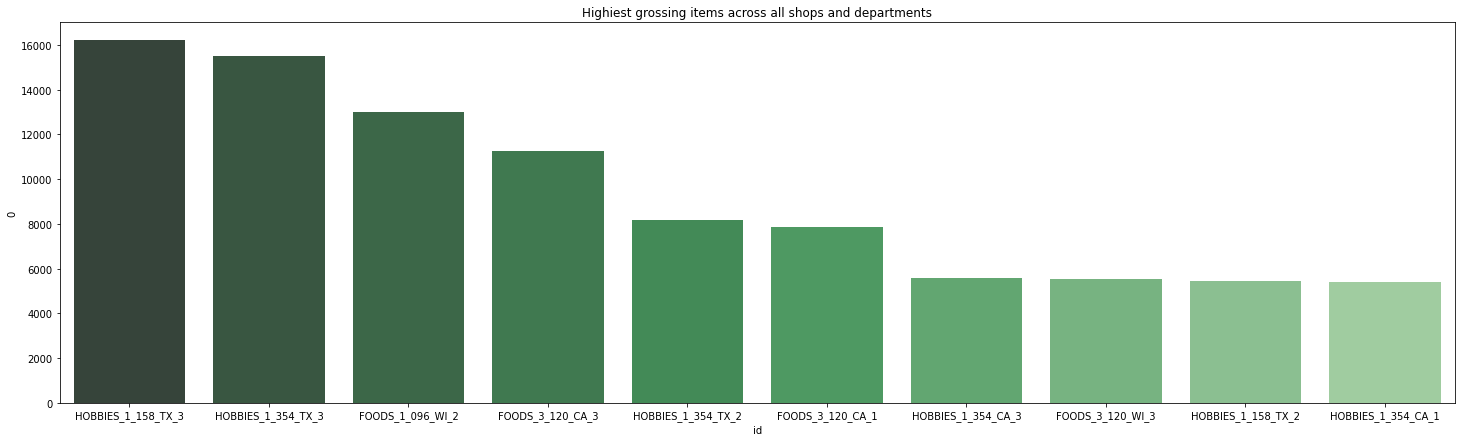

In [33]:

plt.figure(figsize=[25,7])
plt.title('Highiest grossing items across all shops and departments')
sns.barplot(x=highiest_grossing_df.index,\
            y=highiest_grossing_df[0],\
            palette=sns.color_palette("Greens_d", n_colors=10, desat=1))
plt.show()

#HOBBIES_1_354

In [34]:
highiest_grossing_df

,0
id,
HOBBIES_1_158_TX_3,"16,200.90"
HOBBIES_1_354_TX_3,"15,515.36"
FOODS_1_096_WI_2,"13,020.75"
FOODS_3_120_CA_3,"11,264.88"
HOBBIES_1_354_TX_2,"8,187.19"
FOODS_3_120_CA_1,"7,848.48"
HOBBIES_1_354_CA_3,"5,574.73"
FOODS_3_120_WI_3,"5,542.74"
HOBBIES_1_158_TX_2,"5,434.26"


As seen in dataframe and graph above, item 354 from 'Hobbies' section appeared 3x in our top 20 list.
Lets have a look what are the sales for this item across whole dataset + our prediction for next 28 days.

In [35]:
future['ds'].values

array(['2016-04-25T00:00:00.000000000', '2016-04-26T00:00:00.000000000',
       '2016-04-27T00:00:00.000000000', '2016-04-28T00:00:00.000000000',
       '2016-04-29T00:00:00.000000000', '2016-04-30T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-05-02T00:00:00.000000000',
       '2016-05-03T00:00:00.000000000', '2016-05-04T00:00:00.000000000',
       '2016-05-05T00:00:00.000000000', '2016-05-06T00:00:00.000000000',
       '2016-05-07T00:00:00.000000000', '2016-05-08T00:00:00.000000000',
       '2016-05-09T00:00:00.000000000', '2016-05-10T00:00:00.000000000',
       '2016-05-11T00:00:00.000000000', '2016-05-12T00:00:00.000000000',
       '2016-05-13T00:00:00.000000000', '2016-05-14T00:00:00.000000000',
       '2016-05-15T00:00:00.000000000', '2016-05-16T00:00:00.000000000',
       '2016-05-17T00:00:00.000000000', '2016-05-18T00:00:00.000000000',
       '2016-05-19T00:00:00.000000000', '2016-05-20T00:00:00.000000000',
       '2016-05-21T00:00:00.000000000', '2016-05-22

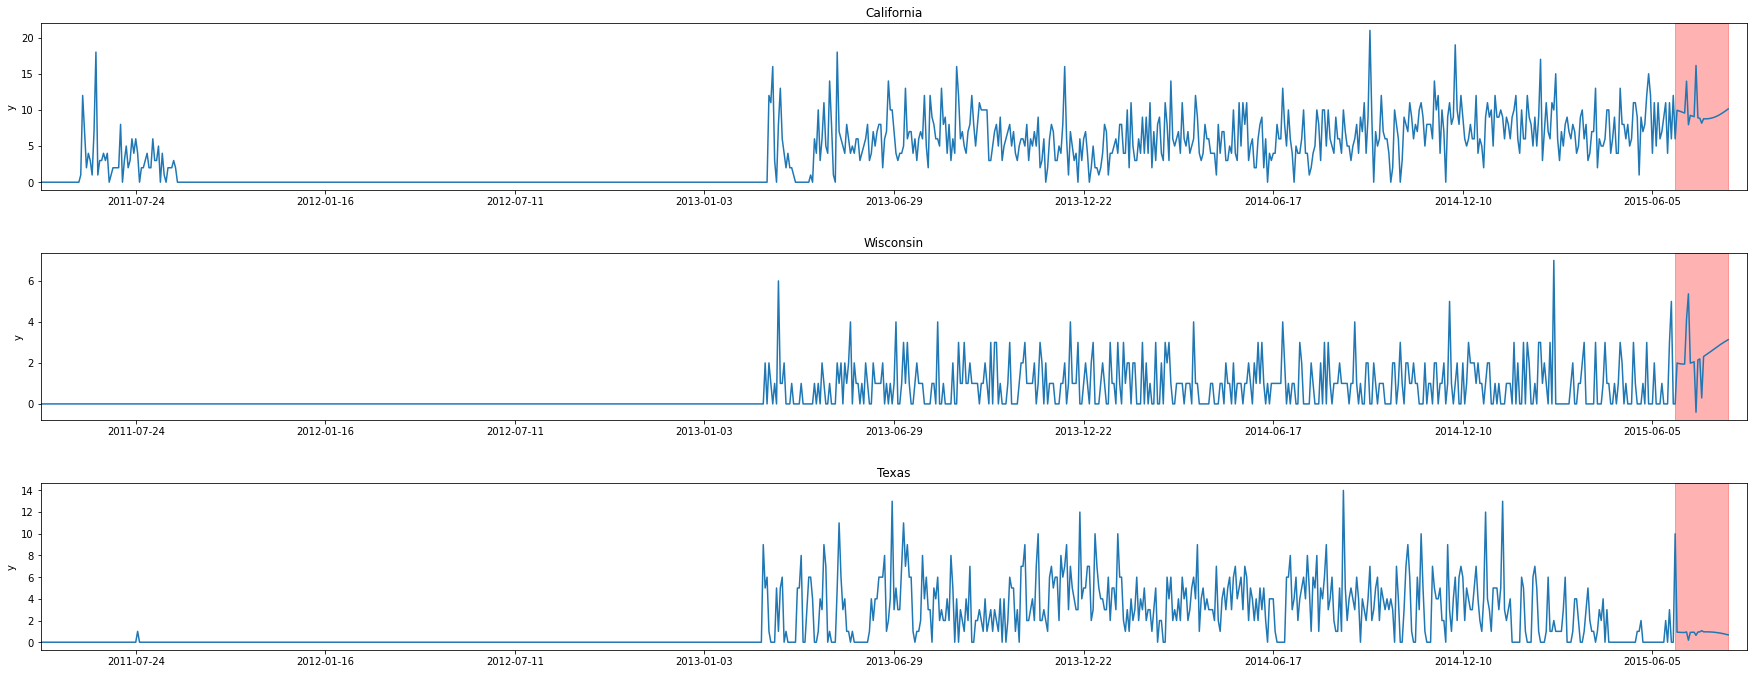

In [36]:
plt.figure(figsize=[25,10])
states = {'CA':'California','WI':'Wisconsin','TX':'Texas'}

for c in range(1,len(states.keys())+1):
  plt.subplot(3,1,c) #position of plot
  plt.xlim(1050,1950) #cut first 1050 days as there were no sales
  state_code = list(states.keys())[c-1] #get state code from states dict

  plt.title(states[state_code]) #set title of plot to state name
  plot_df = pd.DataFrame({'y': list(df[f'HOBBIES_1_354_{state_code}_1'].values.astype('float')) + list(final_df.loc[final_df['id']==f'HOBBIES_1_008_{state_code}_1'].values[0][1:])  })
  sns.lineplot(data=plot_df,x=plot_df.index,y='y')
  plt.gca().set(xticklabels = [pd.date_range(start = '2011-01-29', end= '2016-05-26')[int(1941/11*v)].strftime('%Y-%m-%d') for v in range(10)])

  plt.axvspan(1912,1940,alpha=0.3,label='prediction',color='red')
  plt.tight_layout(pad=3.0)
plt.show()

By inspecting this graph we can tell there is not particularly high deman for this item.

Why it would place in top20 ? Could it be a price ? 

In [37]:
item_prices.loc[item_prices['id'].str[:13]=='HOBBIES_1_354']

,id,sell_price
17820,HOBBIES_1_354_CA_1,23.24
17821,HOBBIES_1_354_CA_2,23.24
17822,HOBBIES_1_354_CA_3,23.23
17823,HOBBIES_1_354_CA_4,23.20
17824,HOBBIES_1_354_TX_1,23.21
17825,HOBBIES_1_354_TX_2,23.26
17826,HOBBIES_1_354_TX_3,23.19
17827,HOBBIES_1_354_WI_1,22.75
17828,HOBBIES_1_354_WI_2,23.19
17829,HOBBIES_1_354_WI_3,22.75


\$23 is not much , but looking at average item price of under \$5, give us understanding why this item places in top 20 list

In [38]:
item_prices['sell_price'].describe()

count              30,490.00
mean                    4.45
std                     3.52
min                     0.19
25%                     2.17
50%                     3.38
75%                     5.81
max                    30.51
Name: sell_price, dtype: float64

#Most popular items
In previous part we have discovered items that will bring most revenue in forecasted 28 days.

This time we will shine some light at items that are being sold the most.

In [39]:
most_popular_items_df = pd.DataFrame(df.sum().sort_values(ascending=False)[:20])

In [40]:
most_popular_items_df['state'] = most_popular_items_df.index.str[12:14]

In [41]:
most_popular_items_df.head(3)

,0,state
id,,
FOODS_3_090_CA_3,"250,502.00",CA
FOODS_3_586_TX_2,"192,835.00",TX
FOODS_3_586_TX_3,"150,122.00",TX


It is not a suprise for supermarket to have food items among most sold ones.

In [42]:
df.sum().sort_values(ascending=False)[:5].index

Index(['FOODS_3_090_CA_3', 'FOODS_3_586_TX_2', 'FOODS_3_586_TX_3',
       'FOODS_3_586_CA_3', 'FOODS_3_090_CA_1'],
      dtype='object', name='id')

In [43]:
%%time
df.set_index(pd.to_datetime(df.index),inplace=True)

CPU times: user 1.74 ms, sys: 0 ns, total: 1.74 ms
Wall time: 1.72 ms


In [44]:
holiday['sunday'],holiday['monday']=None,None


By creating 'monday' and 'sunday' column we can highlight weeks with holiday in our weekly sales graph.

I have decided to show weekly sales instead of daily beacause:
- less data points makes it easier to see and understand 
- by grouping days into weeks , weeks with better sales will differ more from less successful weeks

In [45]:
holiday['sunday'],holiday['monday']=None,None
holiday['monday'] = holiday['ds'].dt.date - holiday['ds'].dt.dayofweek * datetime.timedelta(days=1)
holiday['sunday'] = holiday['ds'].dt.date - (7 - holiday['ds'].dt.dayofweek) * datetime.timedelta(days=1)
holiday.head(3)

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimelike.py:1268: PerformanceWarning:

Adding/subtracting array of DateOffsets to TimedeltaArray not vectorized



,holiday,ds,sunday,monday
0,SuperBowl,2011-02-06,2011-02-05,2011-01-31
1,SuperBowl,2012-02-05,2012-02-04,2012-01-30
2,SuperBowl,2013-02-03,2013-02-02,2013-01-28


[]

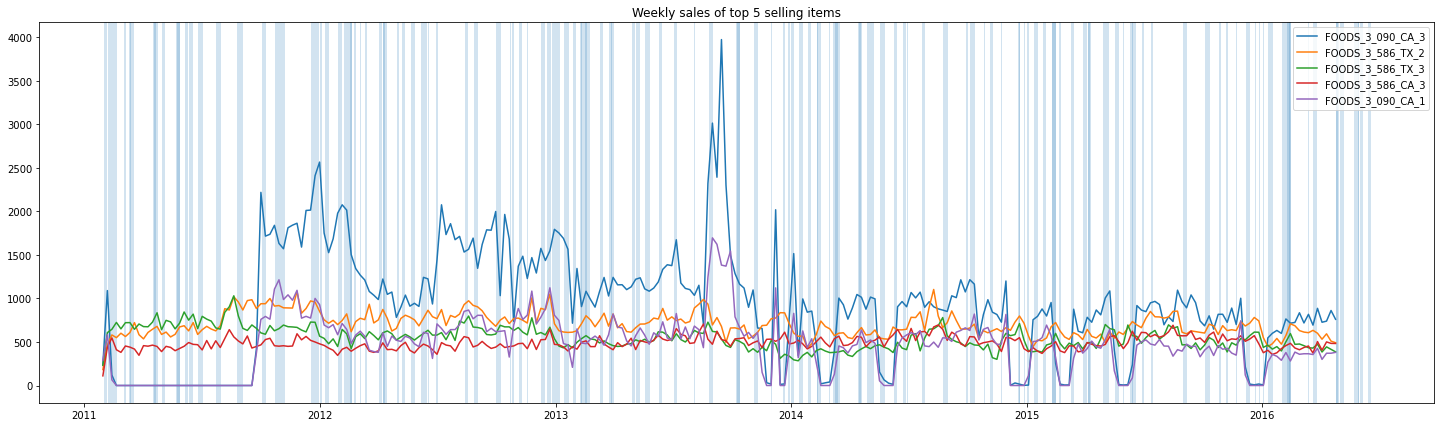

In [46]:
plt.figure(figsize=[25,7])
plt.title('Weekly sales of top 5 selling items')
for i in df.sum().sort_values(ascending=False)[:5].index:

  plt.plot(df[i].groupby(pd.Grouper(level='date',freq='W')).sum(),label=i,)

for d in [v for v in holiday[['monday','sunday']].values]:
  plt.axvspan(d[0],d[1],alpha=0.2)

plt.legend()
plt.plot()

[]

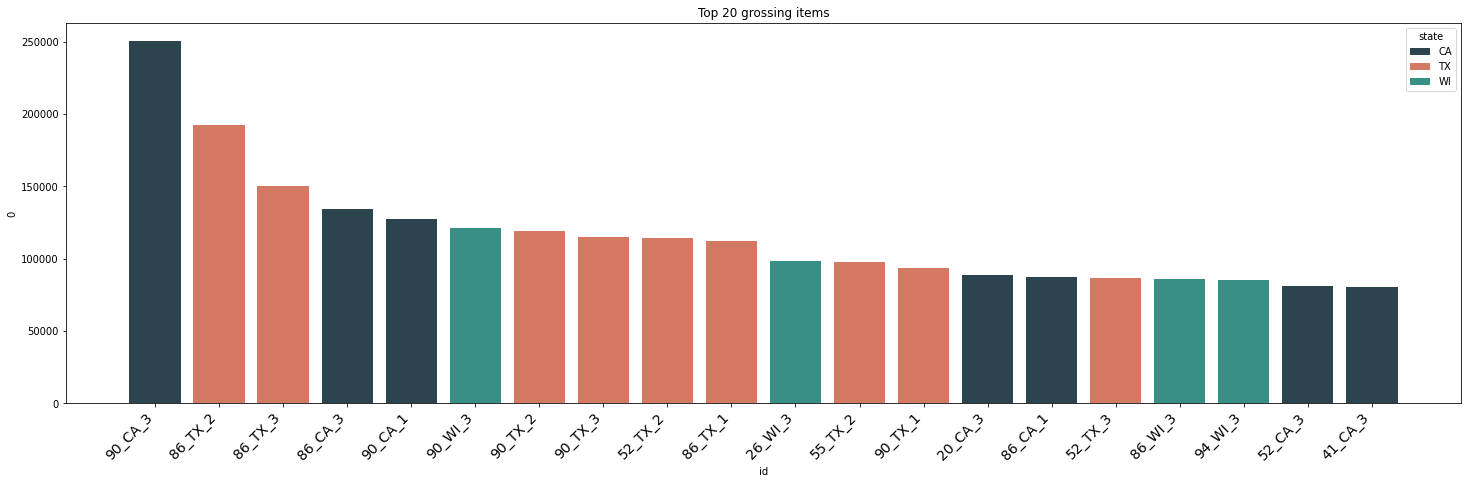

In [47]:
plt.figure(figsize=[25,7])
plt.title('Top 20 grossing items')
sns.barplot(x=most_popular_items_df.index , y=most_popular_items_df[0],hue = most_popular_items_df['state'],palette=['#264653','#e76f51','#2a9d8f'],dodge=False)
plt.gca().set_xticklabels(labels = [v[9:] for v in most_popular_items_df.index ] , rotation = 45, ha="right",size=14)

plt.plot()

#Least proffitable items

This part could be split between least profitable items ever and least profitable items in forecasted future 28 days.

##Least sold items ever

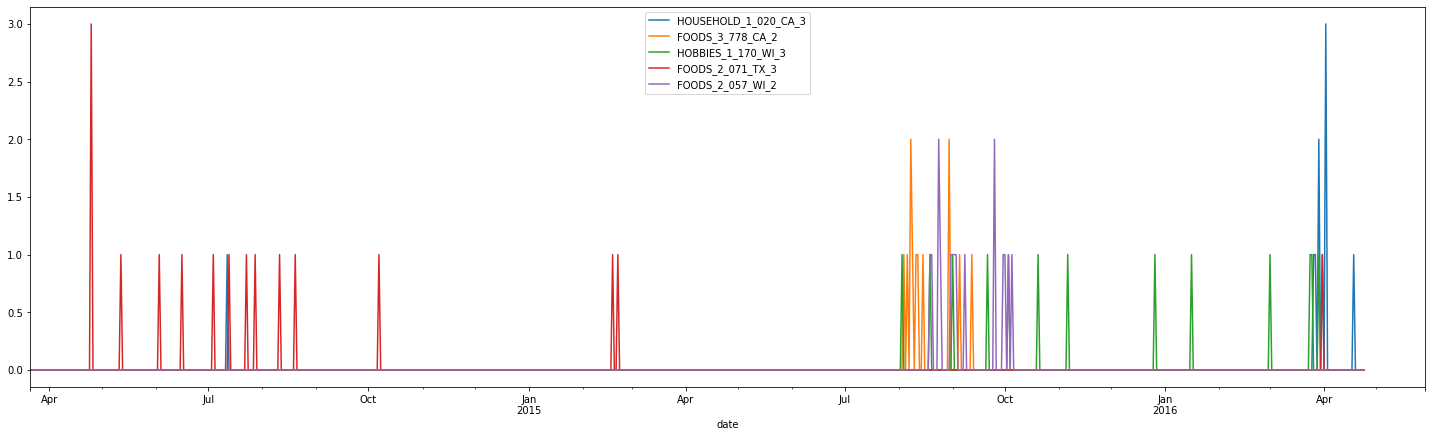

In [48]:
plt.figure(figsize=[25,7])

for c in df.sum().sort_values()[:5].index:
  df[c].plot(label=c)
plt.legend()
plt.xlim(16150,16950)
plt.show()


note - None of the 'least popular products' were sold before April 2014. 

- Majority of 'least popular items' are food items.
Considering food usually have an expiry date and there is not enough demand for those products, they should be removed.

#Discounts 
How much they help ?

- Lets have a look what product have been discounted the most and it they became more popular

If we created price range by 'item_id' instead of 'code' , our results would be innacurate as same item might have different price at different location.

In [49]:
sell_prices['lowest_price'],sell_prices['highiest_price']='',''
sell_prices['code'] = sell_prices['item_id'] +'_'+sell_prices['store_id']

In [50]:
items = [sell_prices['code'].unique()][0] #items names

using .at instead of .loc brought almost 40% speed increase

In [52]:
sell_prices.head(3)

,store_id,item_id,wm_yr_wk,sell_price,code,lowest_price,highiest_price
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES_1_001_CA_1,,
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES_1_001_CA_1,,
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES_1_001_CA_1,,


In [55]:
sell_prices.iat[0,6]

''

In [56]:
#%%time
#%%timeit
index_from = 0
index_to = 0
for item in tqdm(items[:50]):
#for item in tqdm(items):

  #while sell_prices.loc[index_to]['code'] == item:
  #while sell_prices.at[index_to,'code'] == item:
  while sell_prices.iat[index_to,4] == item: #this one is coul save 0.05 s pre loop , which will add up in long run   extime:34.7ms
    index_to+=1



  #price_range = sell_prices.iloc[index_from:index_to]['sell_price'] no improvement
  price_range = sell_prices[index_from:index_to]['sell_price']  #extime:6ms
  

  #sell_prices.loc[index_from:index_to,'lowest_price'] = price_range.min() #  extime:847ms each 
  #sell_prices.loc[index_from:index_to,'highiest_price'] = price_range.max()

  min_price = price_range.min()
  max_price = price_range.max()

  while index_from != index_to:
    sell_prices.iat[index_from,6] = price_range.max()
    print(f'Attaching {index_from}{6} = {max_price}')
    sell_prices.iat[index_from,5] = price_range.min()
    index_from+=1
  
  index_from = index_to #very small impact

#19/06/2020 22:14 1h:22m
#20/06/2020 13:20 51m - iat for checking index


Streaming output truncated to the last 5000 lines.
Attaching 69626 = 0.8
Attaching 69636 = 0.8
Attaching 69646 = 0.8
Attaching 69656 = 0.8
Attaching 69666 = 0.8
Attaching 69676 = 0.8
Attaching 69686 = 0.8
Attaching 69696 = 0.8
Attaching 69706 = 0.8
Attaching 69716 = 0.8
Attaching 69726 = 0.8
Attaching 69736 = 0.8
Attaching 69746 = 0.8
Attaching 69756 = 0.8
Attaching 69766 = 0.8
Attaching 69776 = 0.8
Attaching 69786 = 0.8
Attaching 69796 = 0.8
Attaching 69806 = 0.8
Attaching 69816 = 0.8
Attaching 69826 = 0.8
Attaching 69836 = 0.8
Attaching 69846 = 0.8
Attaching 69856 = 0.8
Attaching 69866 = 0.8
Attaching 69876 = 0.8
Attaching 69886 = 0.8
Attaching 69896 = 0.8
Attaching 69906 = 0.8
Attaching 69916 = 0.8
Attaching 69926 = 0.8
Attaching 69936 = 0.8
Attaching 69946 = 0.8
Attaching 69956 = 0.8
Attaching 69966 = 0.8
Attaching 69976 = 0.8
Attaching 69986 = 0.8
Attaching 69996 = 0.8
Attaching 70006 = 0.8
Attaching 70016 = 0.8
Attaching 70026 = 0.8
Attaching 70036 = 0.8
Attaching 70046 = 0.8
Att

In [ ]:
index_to

I have made some significant progress with finetuning of function below. 

Initially it took over 1h:22m to complete, however after researching pandas functions and their impact on performance I have managed to cut the processing time to just under 3 mins.

Unfortunatelly while I was finishing this code, I came across Panda's error that havent been fixed over last 2 years - https://github.com/pandas-dev/pandas/issues/20643.

When using pandas's .iat method, assigned value turns from float to int.

I have managed to find workaround by assigning string value first and then changing column type to float while keeping high performance.



In [ ]:
sell_prices

In [57]:
%%time
index_from = 0
index_to = 0
for item in tqdm(items):
  try:
    while sell_prices.iat[index_to,4] == item:
      index_to+=1
  except IndexError:
    pass
  
  price_range = sell_prices[index_from:index_to]['sell_price']

  min_price = str(price_range.min())
  max_price = str(price_range.max())

  while index_from !=index_to:

    #sell_prices.loc[index_from:index_to,'lowest_price'] = price_range.min() #  extime:847ms each 

    sell_prices.iat[index_from,5] = min_price
    sell_prices.iat[index_from,6] = max_price



    index_from+=1

#convert back to float 



 
#19/06/2020 22:14   1h:22m - .loc for assigning values
#20/06/2020 13:20   51m - iat for checking index 
#20/06/2020 18:56   2min 52s .iat for assigning values 


CPU times: user 2min 44s, sys: 1.96 s, total: 2min 46s
Wall time: 2min 44s


In [59]:
sell_prices['lowest_price']=pd.to_numeric(sell_prices['lowest_price'])
sell_prices['highiest_price']=pd.to_numeric(sell_prices['highiest_price'])

In [60]:
sell_prices.head(3)

,store_id,item_id,wm_yr_wk,sell_price,code,lowest_price,highiest_price
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES_1_001_CA_1,8.26,9.58
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES_1_001_CA_1,8.26,9.58
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES_1_001_CA_1,8.26,9.58


In [61]:
sell_prices['discount'] = (sell_prices['highiest_price'] - sell_prices['lowest_price']) / sell_prices['highiest_price']

In [63]:
sell_prices.sort_values(by='discount',ascending=False)

,store_id,item_id,wm_yr_wk,sell_price,code,lowest_price,highiest_price,discount
4877298,WI_1,HOBBIES_1_338,11217,8.27,HOBBIES_1_338_WI_1,0.01,8.98,1.00
4877444,WI_1,HOBBIES_1_338,11506,8.98,HOBBIES_1_338_WI_1,0.01,8.98,1.00
4877431,WI_1,HOBBIES_1_338,11445,8.98,HOBBIES_1_338_WI_1,0.01,8.98,1.00
4877432,WI_1,HOBBIES_1_338,11446,8.98,HOBBIES_1_338_WI_1,0.01,8.98,1.00
4877433,WI_1,HOBBIES_1_338,11447,8.98,HOBBIES_1_338_WI_1,0.01,8.98,1.00
...,...,...,...,...,...,...,...,...
3591264,TX_2,HOUSEHOLD_1_241,11231,7.94,HOUSEHOLD_1_241_TX_2,7.94,7.94,0.00
3591265,TX_2,HOUSEHOLD_1_241,11232,7.94,HOUSEHOLD_1_241_TX_2,7.94,7.94,0.00
3591266,TX_2,HOUSEHOLD_1_241,11233,7.94,HOUSEHOLD_1_241_TX_2,7.94,7.94,0.00
3591267,TX_2,HOUSEHOLD_1_241,11234,7.94,HOUSEHOLD_1_241_TX_2,7.94,7.94,0.00


#The end
In this notebook we have predicted 28 days of future sales for 30490 individual items. Also we have gained interesting insight on most popular items.

Hope you have enjoyed this notebook :)